In [1]:
import json
import pystac
import stackstac
import os
import xarray as xr
import geopandas as gpd
from shapely import Polygon
import matplotlib.pyplot as plt
import pandas as pd
import rioxarray as rio
from rasterio.crs import CRS
import rasterio 
import matplotlib.patches as mpatches
import numpy as np
import scipy
from scipy.stats import sem
from statsmodels.stats.stattools import medcouple
from geocube.api.core import make_geocube


# ITSLIVE processing
- read in data from AWS s3, clip to individual glaciers, add dem and process, then save to .nc file
- files are saved in `/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/retreat_itslive_work/processed_results/itslive/413_results`
- havent done this for itsliev yet --> had to drop the minimum coverage thresholding step -- is there a way to vectorize `.where()`? need to return to this, and double check cov is calculated corectly 

In [2]:
import sys
sys.path.insert(0, '/uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/expanding_retreat/')

import retreat_setup_tools
import retreat_processing_tools
import itslive_processing_tools

## RGI data

In [3]:
rgi_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/rgi/'
rgi15 = gpd.read_file(os.path.join(rgi_path, 'rgi15/15_rgi60_SouthAsiaEast.shp'))


In [4]:
rgi15_prj = rgi15.to_crs('EPSG:32645')

Subset `rgi15` to only glaciers that fall within the footprint of cube:

## UTM grid

In [5]:
utm = gpd.read_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/new_retreat/data/utm/World_UTM_Grid(1).geojson')

In [6]:
utm45 = utm.loc[utm['ZONE'] == 45]
utm45 = gpd.sjoin(utm45, rgi15, how='inner')

In [7]:
utm45_prj = utm45.to_crs('EPSG:32645')
utm45_prj = utm45_prj.drop('index_right', axis=1)

## NASADEM

In [65]:
#comparing nasadems for a second, the retreat downsampled one and itslive downsampeld one.
# should be the same except for spatial res

In [8]:
nasadem_fpath = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/nasadem/nasadem_mosaic_itslive_res/425_downsamp_proj_mosaic_dem.nc'

In [9]:
nasadem = xr.open_dataset(nasadem_fpath)

In [13]:
nasadem = nasadem.rio.write_crs('EPSG:32645')

In [14]:
#clip to UTM zone
nasadem_32645 = nasadem.rio.clip(utm45_prj.geometry, utm45_prj.crs)

In [19]:
nasadem_32645

<xarray.Dataset>
Dimensions:              (x: 4962, y: 1878)
Coordinates:
  * x                    (x) float64 2.023e+05 2.024e+05 ... 7.975e+05 7.976e+05
  * y                    (y) float64 2.986e+06 2.987e+06 ... 3.212e+06 3.212e+06
    crs                  int64 0
Data variables:
    Band1                (y, x) float32 nan nan nan nan nan ... nan nan nan nan
    transverse_mercator  |S1 ...
Attributes:
    Conventions:               CF-1.5
    GDAL:                      GDAL 2.2.0dev, released 2016/99/99
    history:                   *
    GDAL_AREA_OR_POINT:        Point
    NCO:                       4.3.7
    nco_openmp_thread_number:  1

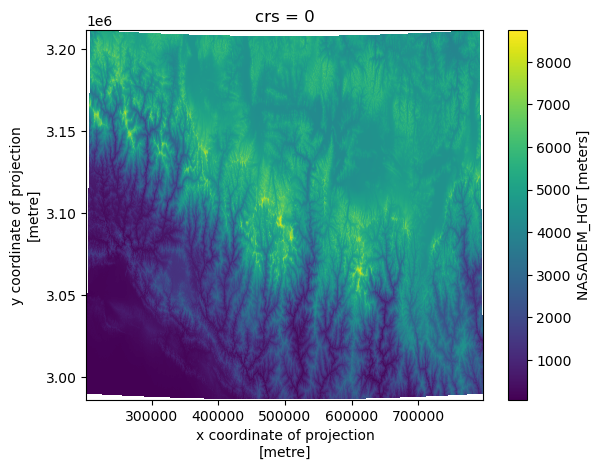

In [17]:
nasadem_32645.Band1.plot()

## Slice the ITSLIVE dem by the extent of the NASADEM?

In [223]:
nasadem_fp = retreat_processing_tools.get_footprint(nasadem, 'xy')

In [224]:
nasadem_fp = nasadem_fp.set_crs('EPSG:32645')

In [225]:
rgi_subset = gpd.sjoin(rgi15_prj, nasadem_fp, how='inner')

In [226]:
rgi_subset = rgi_subset.drop('index_right', axis=1)

In [227]:
rgi_subset['Area'].min()

5.01

In [228]:
len(rgi_subset['RGIId'].to_list()) #nice, rgisubset has 146 glaciers in it, same as for retreat
#now that we're using a different DEM, this is off -- can fix later

174

In [229]:
rgi_ids = rgi_subset['RGIId'].to_list()

<AxesSubplot: >

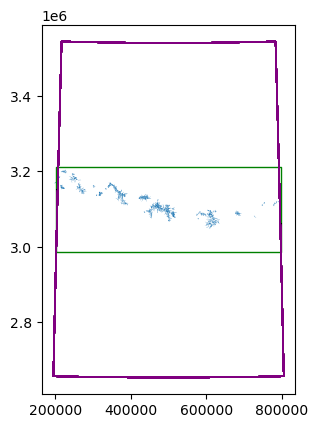

In [230]:
fig, ax = plt.subplots()
rgi_subset.plot(ax=ax)
nasadem_fp.plot(ax=ax, facecolor='None', edgecolor='green')
utm45_prj.to_crs('EPSG:32645').plot(ax=ax, facecolor='None', edgecolor='purple')

In [231]:
outpath = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/retreat_itslive_work/processed_results/retreat/413_results/'

## ITSLIVE

In [232]:
itslive_catalog = gpd.read_file('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json')

In [233]:
itslive_catalog.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [234]:
itslive_granules = gpd.sjoin(itslive_catalog, rgi_subset.to_crs('EPSG:4326'), how='inner')[['roi_percent_coverage','geometry_epsg','datacube_exist','zarr_url','epsg','geometry']]

In [235]:
itslive_granules

,roi_percent_coverage,geometry_epsg,datacube_exist,zarr_url,epsg,geometry
518,61.551920,"{'type': 'Polygon', 'coordinates': [[[700000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32644,"POLYGON ((83.03407 28.01020, 84.05013 27.99140..."
527,79.640980,"{'type': 'Polygon', 'coordinates': [[[200000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32645,"POLYGON ((83.94987 27.99140, 84.96593 28.01020..."
518,61.551920,"{'type': 'Polygon', 'coordinates': [[[700000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32644,"POLYGON ((83.03407 28.01020, 84.05013 27.99140..."
527,79.640980,"{'type': 'Polygon', 'coordinates': [[[200000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32645,"POLYGON ((83.94987 27.99140, 84.96593 28.01020..."
518,61.551920,"{'type': 'Polygon', 'coordinates': [[[700000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32644,"POLYGON ((83.03407 28.01020, 84.05013 27.99140..."
...,...,...,...,...,...,...
627,50.787518,"{'type': 'Polygon', 'coordinates': [[[700000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32645,"POLYGON ((89.03407 28.01020, 90.05013 27.99140..."
637,91.900578,"{'type': 'Polygon', 'coordinates': [[[200000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32646,"POLYGON ((89.94987 27.99140, 90.96593 28.01020..."
627,50.787518,"{'type': 'Polygon', 'coordinates': [[[700000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32645,"POLYGON ((89.03407 28.01020, 90.05013 27.99140..."
627,50.787518,"{'type': 'Polygon', 'coordinates': [[[700000, ...",1,http://its-live-data.s3.amazonaws.com/datacube...,32645,"POLYGON ((89.03407 28.01020, 90.05013 27.99140..."


In [236]:
itslive_granules.explore(style_kwds={'fill':False})

<AxesSubplot: >

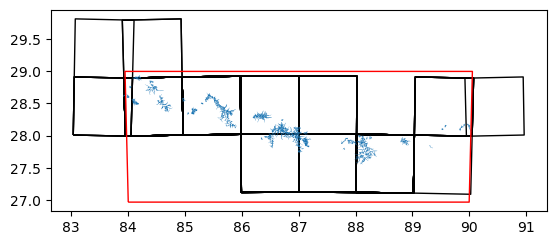

In [237]:
fig, ax = plt.subplots()
itslive_granules.plot(facecolor='None', ax=ax)
rgi_subset.to_crs('EPSG:4326').plot(ax=ax)
nasadem_fp.to_crs('EPSG:4326').plot(ax=ax, facecolor='None', edgecolor='red')

In [238]:
rgi_subset.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

I think best way to go about this is going per granule, and clipping to each glacier in that granule. start by finding which glaciers are in each granule.

<AxesSubplot: >

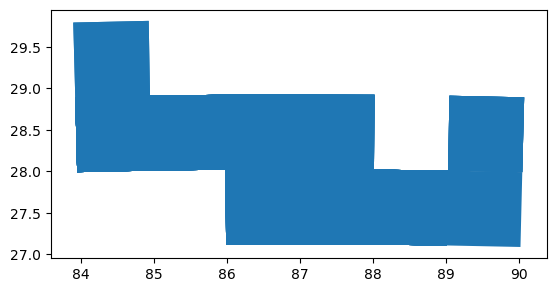

In [239]:
itslive_granules.loc[itslive_granules['epsg'] == 32645].plot()

In [240]:
itslive_granules = itslive_granules.drop_duplicates(subset = 'zarr_url', keep='first')

In [241]:
itslive_granules_32645 = itslive_granules.loc[itslive_granules['epsg'] == 32645]

In [242]:
itslive_urls_32645 = itslive_granules_32645['zarr_url'].to_list()

In [243]:
len(itslive_granules_32645)

10

In [244]:
len(itslive_urls_32645)

10

In [245]:
itslive_urls_32645[0][-37:-5]

'EPSG32645_G0120_X250000_Y3150000'

In [246]:
#this cell makes a dict where each key is the url for an itslive granule, and the values are the rgiids of the glaciers in that granule
url_ls, rgi_ls = [],[]
for i in range(len(itslive_urls_32645)):
    
    url = itslive_granules_32645.loc[itslive_granules_32645['zarr_url'] == itslive_urls_32645[i]]['zarr_url'].values[0]
    url_ls.append(url)
    rgi_ids = gpd.sjoin(rgi_subset, itslive_granules_32645.loc[itslive_granules_32645['zarr_url'] == itslive_urls_32645[i]].to_crs('EPSG:32645'), how='inner')['RGIId'].to_list()
    rgi_ls.append(rgi_ids)
url_dict = dict(zip(url_ls, rgi_ls))

In [247]:
list(url_dict)[0]

'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr'

Read in ITSLIVE single granule:

In [248]:
ds = itslive_processing_tools.read_in_s3(list(url_dict)[2])

In [332]:
nasadem.transverse_mercator.crs.attrs

{'crs_wkt': 'PROJCS["WGS 84 / UTM zone 45N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",87],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32645"]]',
 'semi_major_axis': 6378137.0,
 'semi_minor_axis': 6356752.314245179,
 'inverse_flattening': 298.257223563,
 'reference_ellipsoid_name': 'WGS 84',
 'longitude_of_prime_meridian': 0.0,
 'prime_meridian_name': 'Greenwich',
 'geographic_crs_name': 'WGS 84',
 'horizontal_datum_name': 'World Geodetic System 1984',
 'projected_crs_name': 'WGS 84 / UTM zone 45N',
 'grid_mapping_name': 'trans

In [326]:
ds.mapping.spatial_ref.split(',')


['PROJCS["WGS 84 / UTM zone 45N"',
 'GEOGCS["WGS 84"',
 'DATUM["WGS_1984"',
 'SPHEROID["WGS 84"',
 '6378137',
 '298.257223563',
 'AUTHORITY["EPSG"',
 '"7030"]]',
 'AUTHORITY["EPSG"',
 '"6326"]]',
 'PRIMEM["Greenwich"',
 '0',
 'AUTHORITY["EPSG"',
 '"8901"]]',
 'UNIT["degree"',
 '0.0174532925199433',
 'AUTHORITY["EPSG"',
 '"9122"]]',
 'AUTHORITY["EPSG"',
 '"4326"]]',
 'PROJECTION["Transverse_Mercator"]',
 'PARAMETER["latitude_of_origin"',
 '0]',
 'PARAMETER["central_meridian"',
 '87]',
 'PARAMETER["scale_factor"',
 '0.9996]',
 'PARAMETER["false_easting"',
 '500000]',
 'PARAMETER["false_northing"',
 '0]',
 'UNIT["metre"',
 '1',
 'AUTHORITY["EPSG"',
 '"9001"]]',
 'AXIS["Easting"',
 'EAST]',
 'AXIS["Northing"',
 'NORTH]',
 'AUTHORITY["EPSG"',
 '"32645"]]']

In [221]:
ds_fp = retreat_processing_tools.get_footprint(ds, 'xy').set_crs('EPSG:32645')

In [264]:
its_03976

<xarray.Dataset>
Dimensions:                    (mid_date: 21854, x: 26, y: 31)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2021-09-02T05:10:49....
  * x                          (x) float64 3.079e+05 3.08e+05 ... 3.109e+05
  * y                          (y) float64 3.139e+06 3.139e+06 ... 3.135e+06
Data variables: (12/53)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(21854,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(21854,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(21854,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(21854, 30, 25), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(21854, 30, 25), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(21854,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(21854,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(21854,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(21854,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(21854,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(21854,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(21854,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:22
    date_updated:               14-Jun-2022 04:37:22
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [260]:
its_03976 = ds.rio.clip(rgi_03976.geometry, rgi_03976.crs)

In [303]:
pre_dem_03976 = nasadem.rio.clip(rgi_03976.geometry, rgi_03976.crs)

In [307]:
pre_dem_03976.x.min().data

array(307919.75559836)

In [306]:
its_03976.x.min().data

array(307852.5)

In [266]:
its_03976

dem_03976 = nasadem.sel(x=slice(its_03976.x.min().data, its_03976.x.max().data))
dem_03976 = dem_03976.sel(y=slice(its_03976.y.min().data, its_03976.y.max().data))

In [288]:
dem_03976_clipped = dem_03976.rio.clip(rgi_03976.geometry, rgi_03976.crs)

In [297]:
dem_03976_clipped.y.min().data

array(3135093.11627878)

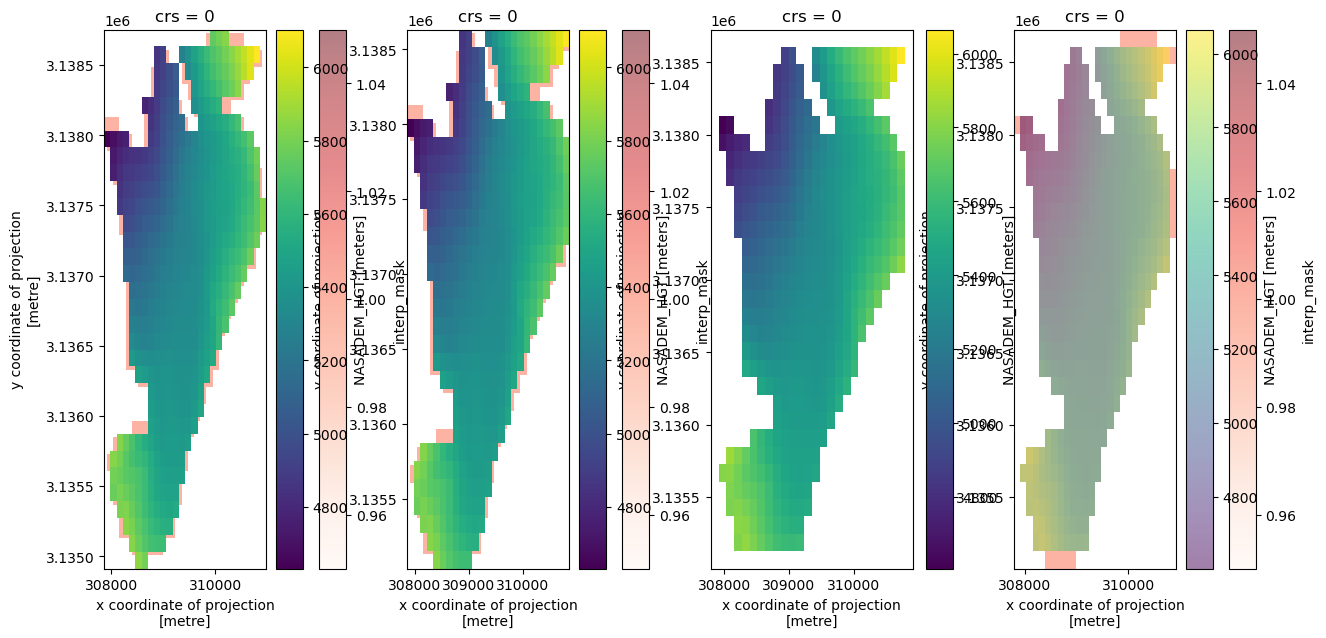

In [315]:
fig, axs = plt.subplots(ncols=4, figsize=(15,7))
its_03976.interp_mask.mean(dim='mid_date').plot(ax=axs[0], cmap = plt.cm.Reds, alpha = 0.5);
its_03976.interp_mask.mean(dim='mid_date').plot(ax=axs[1], cmap = plt.cm.Reds, alpha = 0.5);
pre_dem_03976.Band1.plot(ax=axs[0])
dem_03976_clipped.Band1.plot(ax=axs[1])
dem_03976_interp.Band1.plot(ax=axs[2])
its_03976.interp_mask.mean(dim='mid_date').plot(ax=axs[3], cmap = plt.cm.Reds, alpha = 0.5);
dem_03976_interp.Band1.plot(ax=axs[3],alpha= 0.5)


In [282]:
dem_03976_interp = dem_03976.interp_like(its_03976, method='linear')

In [311]:
dem_03976_interp = dem_03976_interp.rio.clip(rgi_03976.geometry, rgi_03976.crs)

In [298]:
dem_03976.y.min().data

array(3135093.11627878)

In [284]:
dem_03976_interp.Band1

<xarray.DataArray 'Band1' (y: 31, x: 26)>
array([[          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan],
       [          nan, 4395.52845261, 4378.88382919, 4415.38045619,
        4498.85682239, 4586.10217245, 4674.74186561, 4767.96775241,
        4831.43527436, 4882.82049799, 4960.70738867, 5071.77432971,
        5190.36170593, 5301.98817151, 5408.17808089, 5503.67523805,
        5582.03367774, 5649.08782439, 5703.40284852, 5751.22515331,
        5806.91400156, 5864.47953647, 5925.87673625, 5995.33382268,
        6064.90237807,           nan],
       [          nan, 4429.89750332, 4429.9080141 , 4483.83801585,
        4556.00957837, 4620.10380745, 4689.74194565, 4772.81014837,
        4838.86031055, 4889.30296531, 4943.71590481, 5011.18931934,
        5110.92956689, 5244.79560296, 5366.53075763, 5457.21969178,
        5538.90181897, 5610.45427612, 5666.76182487, 5717.01106763,
        5773.6501895 , 5833.42405299, 5901.60271219, 5980.61017049,
...
        5799.63830087, 5744.39012508, 5685.58847689, 5629.47390694,
        5577.08586081, 5541.77695815, 5524.72018957, 5525.92076752,
        5563.93524245, 5636.79442266, 5697.1135175 , 5689.44698364,
        5640.81487566, 5586.36506664, 5516.88092688, 5464.22618323,
        5436.28041039, 5406.60153304, 5375.98346045, 5360.91629053,
        5364.08296771,           nan],
       [          nan, 5513.9850567 , 5667.75542065, 5787.40611639,
        5821.30647592, 5779.91541422, 5716.8007296 , 5661.51291933,
        5618.13801977, 5591.83920856, 5581.37550141, 5595.67269793,
        5641.53964047, 5675.62505461, 5652.90665736, 5583.12055092,
        5509.00780272, 5440.22962778, 5373.12356015, 5321.7509497 ,
        5292.14118197, 5278.91207671, 5273.13366655, 5276.24040535,
        5289.65467582,           nan],
       [          nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan,           nan,           nan,
                  nan,           nan]])
Coordinates:
    crs      int64 0
  * y        (y) float64 3.139e+06 3.139e+06 3.138e+06 ... 3.135e+06 3.135e+06
  * x        (x) float64 3.079e+05 3.08e+05 3.081e+05 ... 3.107e+05 3.109e+05
Attributes:
    long_name:      NASADEM_HGT
    grid_mapping:   crs
    standard_name:  height
    units:          meters

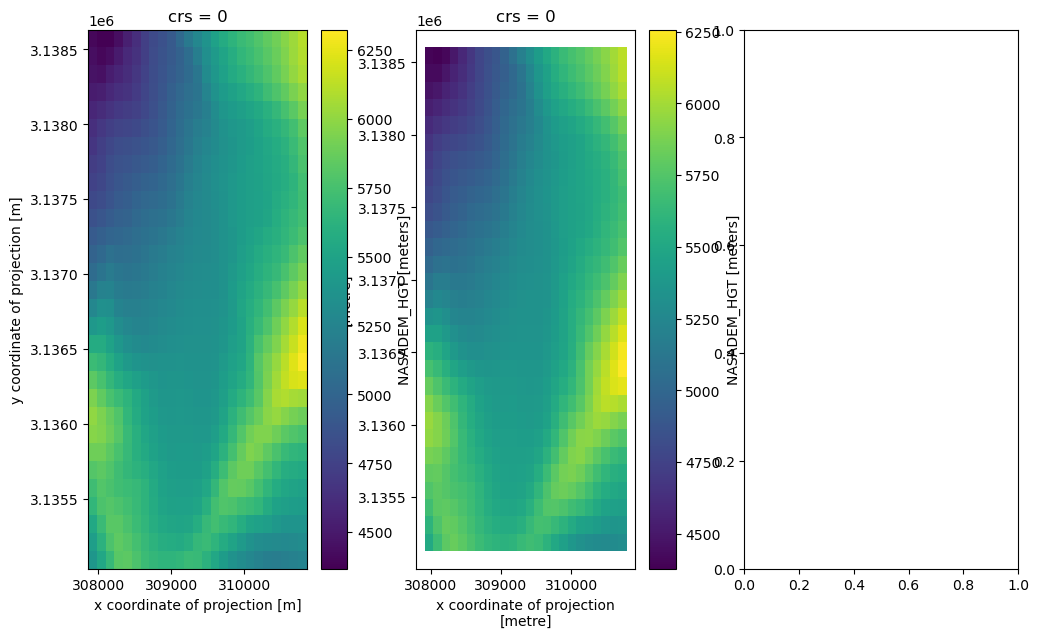

In [287]:
fig,axs = plt.subplots(ncols=3, figsize=(12,7))
dem_03976.Band1.plot(ax=axs[0])
dem_03976_interp.Band1.plot(ax=axs[1])


In [249]:
dem_clip = nasadem.rio.clip_box(
    minx = float(ds.x.min().data),
    miny = float(ds.y.min().data),
    maxx = float(ds.x.max().data),
    maxy = float(ds.y.max().data),
)

In [250]:
print('x min itslive , x min dem (meters): ') 
print(ds.x.min().data, ', ', dem_clip.x.min().data)

x min itslive , xm min dem (meters): 
300052.5 ,  299999.7555983575


In [256]:
print('x max itslive, xmax dem (meters): ') 
print(ds.x.max().data, ', ', dem_clip.x.max().data)

x max itslive, xmax dem (meters): 
400012.5 ,  399959.7555983575


In [257]:
print('y min itslive, ymin dem (meters): ') 
print(ds.y.min().data, ', ', dem_clip.y.min().data)

y min itslive, ymin dem (meters): 
3100027.5 ,  3100053.1162787816


In [258]:
print('y max itslive, ymax dem (meters): ') 
print(ds.y.max().data, ', ', dem_clip.y.max().data)

y max itslive, ymax dem (meters): 
3199867.5 ,  3199893.1162787816


In [150]:
dem_clip.x.min().data

array(299999.75559836)

In [177]:
dem_clip_fp

,geometry
0,"POLYGON ((300119.756 3100053.116, 300119.756 3..."


In [169]:
rgi_subset.head()
rgi_single = rgi_subset.loc[rgi_subset['RGIId'] == 'RGI60-15.02235']

In [185]:
rgi_granule0 = gpd.sjoin(rgi_subset, ds_fp, how='inner')

In [186]:
rgi_granule0.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
108,RGI60-15.03976,G085055E28346N,20001122,-9999999,85.054817,28.345892,15,1,6.686,4598,...,4052,0,0,0,0,9,9,NaN,"POLYGON ((308663.373 3137982.851, 308663.373 3...",0
110,RGI60-15.04060,G084967E28552N,20011024,-9999999,84.967453,28.552441,15,1,8.385,3745,...,7788,0,0,0,0,9,9,NaN,"POLYGON ((301405.276 3159022.291, 301402.929 3...",0
117,RGI60-15.04119,G085645E28262N,20010922,-9999999,85.644977,28.262351,15,1,11.836,4179,...,12856,0,0,0,0,9,9,NaN,"POLYGON ((369296.684 3130867.436, 369311.555 3...",0
118,RGI60-15.04121,G085670E28312N,20010922,-9999999,85.669846,28.312454,15,1,37.792,4505,...,18899,0,0,0,0,9,9,NaN,"POLYGON ((373193.745 3139566.043, 373207.593 3...",0
119,RGI60-15.04137,G084966E28572N,20010922,-9999999,84.966480,28.571946,15,1,5.609,4635,...,5575,0,0,0,0,9,9,NaN,"POLYGON ((302262.286 3162877.289, 302283.026 3...",0


In [187]:
rgi_03976 = rgi_granule0.loc[rgi_granule0['RGIId'] == 'RGI60-15.03976'] 

In [206]:
dem_clip = dem_clip.interp_like(ds)

In [208]:
dem_clip.x.min().data

array(300052.5)

In [209]:
ds.x.min().data

array(300052.5)

In [192]:
rgi_03976.crs

<Derived Projected CRS: EPSG:32645>
Name: WGS 84 / UTM zone 45N
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Between 84°E and 90°E, northern hemisphere between equator and 84°N, onshore and offshore. Bangladesh. Bhutan. China. India. Kazakhstan. Mongolia. Nepal. Russian Federation.
- bounds: (84.0, 0.0, 90.0, 84.0)
Coordinate Operation:
- name: UTM zone 45N
- method: Transverse Mercator
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: title={'center': 'crs = 0'}, xlabel='projection_x_coordinate', ylabel='projection_y_coordinate'>

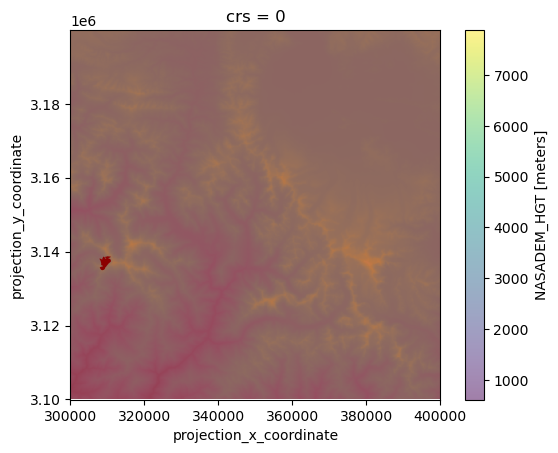

In [210]:
fig, ax = plt.subplots()

dem_clip.Band1.plot(ax=ax, alpha = 0.5)
#dem_clip_fp.plot(ax=ax, alpha= 0.1)
ds_fp.plot(ax=ax, alpha = 0.5, color='darkred')
rgi_03976.plot(ax=ax, color='darkred')

In [211]:
dem_03976 = dem_clip.Band1.rio.clip(rgi_03976.geometry, rgi_03976.crs)

In [212]:
ds_03976 = ds.rio.clip(rgi_03976.geometry, rgi_03976.crs)

In [218]:
dem_03976.x.max().data

array(310852.5)

In [217]:
ds_03976.x.max().data

array(310852.5)

<AxesSubplot: title={'center': 'mapping = 0'}, xlabel='projection_x_coordinate', ylabel='projection_y_coordinate'>

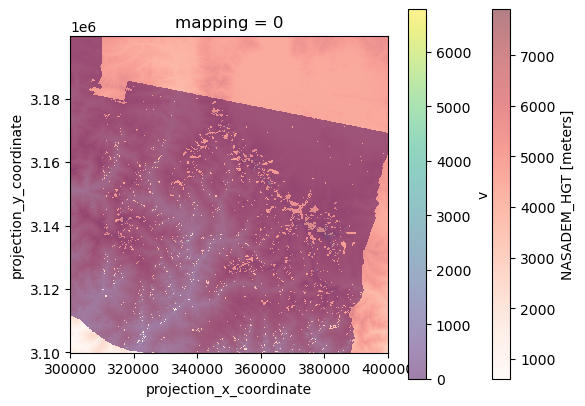

In [174]:
fig, ax = plt.subplots()
dem_clip.Band1.plot(ax=ax, alpha = 0.5, cmap=plt.cm.Reds)
ds.v.isel(mid_date=slice(140,150)).mean(dim='mid_date').plot(ax=ax, alpha = 0.5)
rgi_02263.plot(ax=ax, color='red')

In [106]:
ds.dims

Frozen({'mid_date': 21854, 'y': 833, 'x': 834})

In [117]:
dem_clip = nasadem.rio.clip_box(
    minx = float(ds.x.min().data),
    miny = float(ds.y.min().data),
    maxx = float(ds.x.max().data),
    maxy = float(ds.y.max().data),
)

In [124]:
dem_clip.y.max()

<xarray.DataArray 'y' ()>
array(3199893.11627878)
Coordinates:
    crs      int64 0

In [71]:
ds_fp = retreat_processing_tools.get_footprint(ds, 'xy')

In [72]:
ds_fp = ds_fp.set_crs('EPSG:32645')

<AxesSubplot: >

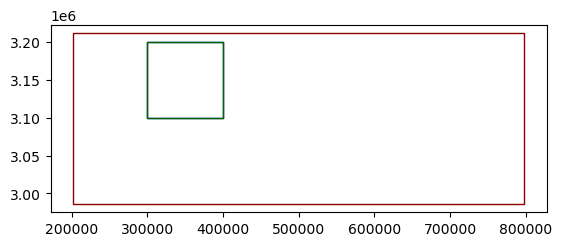

In [109]:
fig, ax = plt.subplots()

nasadem_fp.plot(ax=ax, facecolor='None', edgecolor='darkred')
ds_fp.plot(ax=ax, facecolor='None', edgecolor='darkblue')
dem_clip_fp.plot(ax=ax, facecolor='None', edgecolor='darkgreen')

In [104]:
dem_clip = nasadem.rio.clip(ds_fp.geometry, ds_fp.crs)

In [108]:
dem_clip_fp = retreat_processing_tools.get_footprint(dem_clip,'xy')

In [107]:
dem_clip.dims

Frozen({'x': 833, 'y': 832})

## ITSLIVE granule 2 process

In [85]:
from osgeo import gdal

In [92]:
kwargs = {'format':'NetCDF'}

In [98]:
destNameOrDestDS = '/uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/testtesttest_itslive_gran.nc'

In [101]:
srcDSOrSrcDSTab = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/nasadem/nasadem_mosaic_itslive_res/425_downsamp_proj_mosaic_dem.nc'

In [103]:
clip_dem = gdal.Warp(srcDSOrSrcDSTab, destNameOrDestDS, cutlineDSName=ds_fp, cropToCutline=True)

ERROR 4: /uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/testtesttest_itslive_gran.nc: No such file or directory


TypeError: object of wrong GDALDatasetShadow

In [80]:
dem_granule2 = nasadem.sel(x=slice(ds.x.min().data, ds.x.max().data))

In [83]:
dem_granule2.

<xarray.Dataset>
Dimensions:              (y: 1878, x: 833)
Coordinates:
  * x                    (x) float64 3.001e+05 3.002e+05 ... 3.998e+05 4e+05
  * y                    (y) float64 2.986e+06 2.987e+06 ... 3.212e+06 3.212e+06
    crs                  int64 0
Data variables:
    Band1                (y, x) float32 ...
    transverse_mercator  |S1 ...
Attributes:
    Conventions:               CF-1.5
    GDAL:                      GDAL 2.2.0dev, released 2016/99/99
    history:                   *
    GDAL_AREA_OR_POINT:        Point
    NCO:                       4.3.7
    nco_openmp_thread_number:  1

In [81]:
ds.x.min().data

array(300052.5)

In [82]:
dem_granule2.x.min().data

array(300119.75559836)

In [170]:
gpd.read_file('/uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/aux_data/itslive_granule_footprints/its_tile_EPSG32645_G0120_X250000_Y3150000.shp')

,FID,geometry
0,0,"POLYGON ((200092.500 3100027.500, 200092.500 3..."


In [335]:
gran0_glaciers = url_dict['http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr']

In [ ]:
for key in url_dict:
    
    url = key
    glaciers = url_dict[key]
    
    

In [336]:
gran0_glaciers

['RGI60-15.03986',
 'RGI60-15.04060',
 'RGI60-15.04070',
 'RGI60-15.04071',
 'RGI60-15.04098',
 'RGI60-15.04100',
 'RGI60-15.04101',
 'RGI60-15.04118',
 'RGI60-15.04137',
 'RGI60-15.04149',
 'RGI60-15.04151',
 'RGI60-15.04474',
 'RGI60-15.04515',
 'RGI60-15.04541',
 'RGI60-15.04600',
 'RGI60-15.04611',
 'RGI60-15.04631',
 'RGI60-15.04653',
 'RGI60-15.04676',
 'RGI60-15.04679',
 'RGI60-15.04714',
 'RGI60-15.04717',
 'RGI60-15.04719',
 'RGI60-15.04757',
 'RGI60-15.04766',
 'RGI60-15.04768',
 'RGI60-15.04813',
 'RGI60-15.05140',
 'RGI60-15.09106',
 'RGI60-15.10987']

In [126]:
gran_shp_path = '/uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/aux_data/itslive_granule_footprints/'
clipped_dems_dir = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/nasadem/take3_nasadem_copped_to_itslive_granules/'
full_dem = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/nasadem/nasadem_mosaic_itslive_res/425_downsamp_proj_mosaic_dem.nc'
command = ""
for tile in range(len(list(url_dict))):
    ds = itslive_processing_tools.read_in_s3(list(url_dict)[tile])
    ds_id = list(url_dict)[tile][-37:-5]
    xres = ds.dims['x']
    yres = ds.dims['y']
    crs = list(url_dict)[tile][-33:-28]
    print(crs)
    xmin = ds.x.min().data
    xmax = ds.x.max().data
    ymin = ds.y.min().data
    ymax = ds.y.max().data
    print(ds_id)
    ds_fp = retreat_processing_tools.get_footprint(ds, 'xy')
    ds_fp = ds_fp.set_crs(f'EPSG:{crs}')
    
    ds_fp.to_file(os.path.join(gran_shp_path, f'its_tile_{list(url_dict)[tile][-37:-5]}.shp'))
    
    
    input_fpath = os.path.join(gran_shp_path, f'its_tile_{ds_id}.shp')
    out_fpath = os.path.join(clipped_dems_dir, f'dem_clipped_to_tile_{ds_id}.nc')
    
    command += f'gdalwarp -cutline {input_fpath} -s_srs EPSG:{crs} -t_srs EPSG:{crs} -crop_to_cutline -tap -tr 120 120 -te {xmin} {ymin} {xmax} {ymax} -r bilinear -co UNIFIED_SRC_NODATA=YES NETCDF:{full_dem} {out_fpath}\n'

cmd_file = '/uufs/chpc.utah.edu/common/home/u1269862/2023/expanding_retreat/aux_data/itslive_granule_footprints/clipDEMtoITSLIVEgranules.sh'
f = open(os.path.join(cmd_file), 'w')

f.write(command)
f.close()
    

32645
EPSG32645_G0120_X250000_Y3150000
32645
EPSG32645_G0120_X250000_Y3250000
32645
EPSG32645_G0120_X350000_Y3150000
32645
EPSG32645_G0120_X450000_Y3050000
32645
EPSG32645_G0120_X550000_Y3050000
32645
EPSG32645_G0120_X450000_Y3150000
32645
EPSG32645_G0120_X550000_Y3150000
32645
EPSG32645_G0120_X650000_Y3050000
32645
EPSG32645_G0120_X750000_Y3050000
32645
EPSG32645_G0120_X750000_Y3150000


## Reading in clipped NASADEMS

In [131]:
clipped_dem_dir = '/uufs/chpc.utah.edu/common/home/cryosphere/emarshall/nasadem/take3_nasadem_copped_to_itslive_granules'
clipped_dem_ls = os.listdir(clipped_dem_dir)

In [132]:
clipped_dem_ls

['dem_clipped_to_tile_EPSG32645_G0120_X250000_Y3150000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X250000_Y3250000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X350000_Y3150000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X450000_Y3050000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X550000_Y3050000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X450000_Y3150000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X550000_Y3150000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X650000_Y3050000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X750000_Y3050000.nc',
 'dem_clipped_to_tile_EPSG32645_G0120_X750000_Y3150000.nc']

In [133]:
url_dict.keys()

dict_keys(['http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3250000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X350000_Y3150000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3050000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3050000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3150000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X550000_Y3150000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X650000_Y3050000.zarr', 'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPS

In [140]:
ds_gran1 = itslive_processing_tools.read_in_s3('http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X450000_Y3050000.zarr')

dem_gran1 = xr.open_dataset(os.path.join(clipped_dem_dir, clipped_dem_ls[3]))

In [141]:
dem_gran1 = dem_gran1.drop('transverse_mercator')

In [142]:
print('comparing xmins: ')
print(ds_gran1.x.min().data)
print(dem_gran1.x.min().data)

comparing xmins: 
400132.5
400140.0


In [143]:
print('comparing ymins: ')
print(ds_gran1.y.min().data)
print(dem_gran1.y.min().data)

comparing ymins: 
3000067.5
3000060.0


In [144]:
print('comparing xmaxs: ')
print(ds_gran1.x.max().data)
print(dem_gran1.x.max().data)

comparing xmaxs: 
499972.5
499980.0


In [145]:
print('comparing ymaxs: ')
print(ds_gran1.y.max().data)
print(dem_gran1.y.max().data)

comparing ymaxs: 
3099907.5
3099900.0


In [294]:
dem_gran1['Band1'] = dem_gran1['Band1'].rio.write_crs('EPSG:32645')

In [295]:
ds_gran1.rio.crs

CRS.from_epsg(32645)

In [296]:
dem_fp = dem_fp.set_crs('EPSG:32645')
ds_fp = ds_fp.set_crs('EPSG:32645')

In [213]:
dem_fp = retreat_processing_tools.get_footprint(dem_gran1, 'xy')
ds_fp  = retreat_processing_tools.get_footprint(ds_gran1, 'xy')

In [270]:
def compare_footprints(ds_fp, dem_fp):
    
    ds_xmin = ds_fp.bounds['minx']
    ds_ymin = ds_fp.bounds['miny']
    ds_xmax = ds_fp.bounds['maxx']
    ds_ymax = ds_fp.bounds['maxy']
    
    ds_d = {'minx':ds_xmin, 'miny':ds_ymin, 'maxx':ds_xmax, 'maxy':ds_ymax}
    ds_df = pd.DataFrame(ds_d, index=[0])
    
    dem_xmin = dem_fp.bounds['minx']
    dem_ymin = dem_fp.bounds['miny']
    dem_xmax = dem_fp.bounds['maxx']
    dem_ymax = dem_fp.bounds['maxy']
    
    dem_d = {'minx':dem_xmin, 'miny':dem_ymin,'maxx':dem_xmax, 'maxy':dem_ymax}
    dem_df = pd.DataFrame(dem_d, index=[0])
    
    combine_df = pd.concat([ds_df, dem_df])
    
    max_vals = combine_df[['minx','miny']].max()
    min_vals = combine_df[['maxx','maxy']].min()
    
    xmin = max_vals['minx']
    ymin = max_vals['miny']
    xmax = min_vals['maxx']
    ymax = min_vals['maxy']
    
    vals = {'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax}
    
    bbox = [xmin, ymin, xmax, ymax]
        
    footprint = Polygon([
                [bbox[0], bbox[1]],
                [bbox[0], bbox[3]],
                [bbox[2], bbox[3]],
                [bbox[2], bbox[1]]
                ])
    poly = Polygon(footprint)
    #vals_df = pd.DataFrame(vals, index=[0])
    
    gdf = gpd.GeoDataFrame(index=[0], crs = 'EPSG:32645', geometry = [footprint])
    #vals_gdf = gpd.GeoDataFrame(vals_df, geometry = gpd.ponits_from_xy(df.xmin)
    gdf['name'] = 'test'
    return gdf

In [271]:
inner_footprint = compare_footprints(ds_fp, dem_fp)

In [273]:
inner_footprint

,geometry,name
0,"POLYGON ((400140.000 3000067.500, 400140.000 3...",test


In [297]:
#Now, want to clip both the dem and the granule ds by the above polygon 
ds_gran1_clip = ds_gran1.rio.clip(inner_footprint.geometry, inner_footprint.crs)
dem_gran1_clip = dem_gran1.rio.clip(inner_footprint.geometry, inner_footprint.crs)

In [300]:
ds_gran1_clip.x.min().data

array(400252.5)

In [301]:
dem_gran1_clip.x.min().data

array(400260.)

In [302]:
print(ds_gran1_clip.x.max().data)
print(dem_gran1_clip.x.max().data)

499972.5
499860.0


<AxesSubplot: >

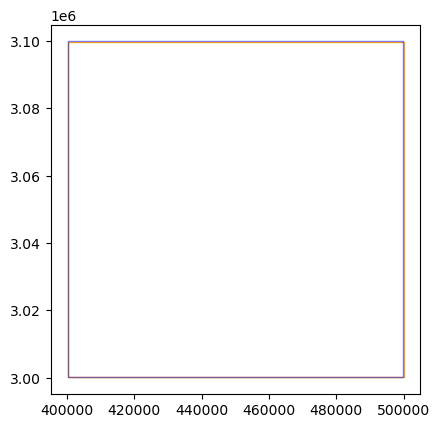

In [217]:
fig, ax = plt.subplots()

dem_fp.plot(ax=ax, facecolor='None', alpha = 0.9, edgecolor='orange')
ds_fp.plot(ax=ax, facecolor='None', alpha = 0.5, edgecolor='blue')

In [248]:
def velocity_clip(ds, rgi):
    
    ds_clip = ds.rio.clip(rgi.geometry, rgi.crs)
    
    return ds_clip

def dem_clip(ds, dem, rgi):
    
    dem_clip = dem.rio.clip(rgi.geometry, rgi.crs)
    ds['z'] = dem_clip.Band1
    
    return ds

def elevation_format(ds):
    
    z_lower = ds.where(ds.z <= np.nanmedian(ds.z.data), drop=True)
    z_upper = ds.where(ds.z > np.nanmedian(ds.z.data), drop=True)
    
    ds['z_lower'] = z_lower.z
    ds['z_upper'] = z_upper.z
    
    return ds

def calc_valid(arr):
    
    i = np.count_nonzero(~np.isnan(arr))
    
    return i

def calc_full_cov(ds):
    
    possible = np.count_nonzero(~np.isnan(ds.v.mean(dim='mid_date')))
    
    actual = xr.apply_ufunc(calc_valid,
                            ds.v,
                            input_core_dims=[['x','y']],
                            exclude_dims=set(('x','y')),
                            vectorize=True,
                            dask='parallelized')
    cov = actual / possible
    ds['full_actual'] = actual
    ds['full_possible'] = possible
    ds['full_cov'] = cov
    
    return ds

def calc_lower_cov(ds):
    
    ds_sub = ds.where(ds.z <= np.nanmedian(ds.z.data),drop=True)
    possible = np.count_nonzero(~np.isnan(ds_sub.v.mean(dim='mid_date')))
    actual = xr.apply_ufunc(calc_valid,
                            ds_sub.v,
                            input_core_dims=[['x','y']],
                            exclude_dims=set(('x','y')),
                            vectorize=True,
                            dask='parallelized')
    cov = actual / possible
    ds['lower_actual'] = actual
    ds['lower_possible'] = possible
    ds['lower_cov'] = cov
    return ds

def calc_upper_cov(ds):
    
    ds_sub = ds.where(ds.z > np.nanmedian(ds.z.data),drop=True)
    possible = np.count_nonzero(~np.isnan(ds_sub.v.mean(dim='mid_date')))
    actual = xr.apply_ufunc(calc_valid,
                            ds_sub.v,
                            input_core_dims=[['x','y']],
                            exclude_dims=set(('x','y')),
                            vectorize=True,
                            dask='parallelized')
    
    cov = actual / possible
    ds['upper_actual'] = actual
    ds['upper_possible'] = possible
    ds['upper_cov'] = cov
    return ds

def calc_area_cov_index(ds):
    
    aci = (ds['upper_cov'] / ds['full_cov']) * (ds['upper_cov'] / (ds['upper_cov'] + ds['lower_cov']))
    
    ds['aci'] = aci
    
    return ds

def add_mask_var(ds, rgi):
    '''rasterize shapefile of single glacier and add it as a var to ds object
    '''
    outline_mask = make_geocube(
        vector_data = rgi,
        measurements=['Area'],
        like=ds.v,
        fill=-999.)
    ds['mask'] = outline_mask['Area']
    
    return ds

def trim_cov(ds, threshold):
    
    #ds = ds.where(ds['full_cov'] >= threshold, drop=True)
    ds = ds.where(ds['full_cov'] >= threshold,drop=True)
    
    return ds 

def same_season_acquisitions(ds):
    
    ds = ds.where(ds.acquisition_date_img1.dt.season == ds.acquisition_date_img2.dt.season, drop=True)
    return ds

In [249]:
def itslive_processing_driver(itslive_raster, dem_raster, rgi_id, rgi_gpdf, threshold):
    
    rgi_single = rgi_gpdf.loc[rgi_gpdf['RGIId'] == rgi_id]
    
    ds_clip = velocity_clip(itslive_raster, rgi_single)
    print('velocity cilpped')
    ds_clip = add_mask_var(ds_clip, rgi_single)
    
    ds_clip = dem_clip(ds_clip, dem_raster, rgi_single)
    print('dem clipped')
    ds_clip = elevation_format(ds_clip)
    
    ds_clip = ds_clip.load()
    print('obj loaded')
    ds_clip = calc_full_cov(ds_clip)
    
    ds_clip = calc_lower_cov(ds_clip)
    
    ds_clip = calc_upper_cov(ds_clip)
    
    ds_clip = calc_area_cov_index(ds_clip)
    print('cov stuff done')
    ds_clip = trim_cov(ds_clip, threshold)
    print('cov trim done')
    
    ds_clip = same_season_acquisitions(ds_clip)
    #ds_clip = reformat_attrs(ds_clip)
    #print('attrs reformatted')
    return ds_clip

In [266]:
its_clip = velocity_clip(ds, rgi_single)

In [278]:
dem_clip = nasadem_granule.rio.clip(rgi_single.geometry, rgi_single.crs)

In [281]:
its_clip.x.min()

<xarray.DataArray 'x' ()>
array(307852.5)
Coordinates:
    mapping  int64 0
    crs      int64 0

In [280]:
dem_clip.x.min()

<xarray.DataArray 'x' ()>
array(307951.73692752)
Coordinates:
    crs      int64 0

In [267]:
its_clip = dem_clip(its_clip, nasadem_granule, rgi_single)

In [272]:
nasadem_granule.x.min()

<xarray.DataArray 'x' ()>
array(301591.73692752)
Coordinates:
    crs      int64 0

In [271]:
ds.x.min()

<xarray.DataArray 'x' ()>
array(300052.5)
Coordinates:
    mapping  int64 0

In [252]:
test1 = itslive_processing_driver(ds, nasadem_granule, list(url_dict.values())[1][0], rgi_subset, 0.5)

velocity cilpped
dem clipped


/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


obj loaded


/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,
/uufs/chpc.utah.edu/common/home/u1269862/software/pkg/miniconda3/envs/stac_work/lib/python3.11/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


cov stuff done
cov trim done


(array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

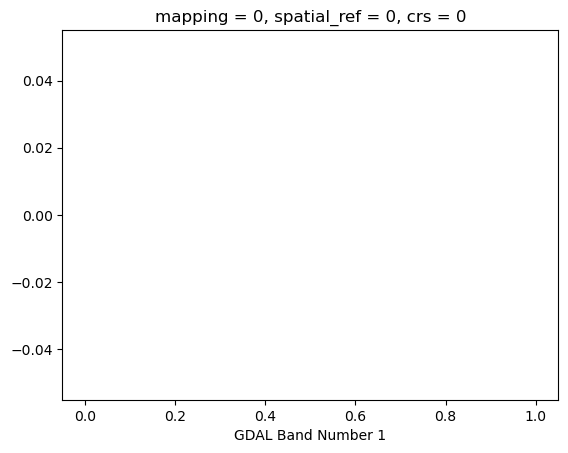

In [265]:
test1.z.plot()

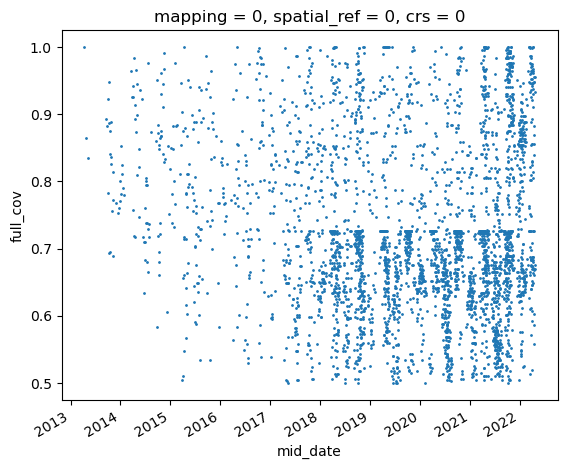

In [260]:
test1.full_cov.plot(marker='o', linestyle='None', markersize=1)

In [117]:
#for key in url_dict.keys():
    
    #ds = itslive_processing_tools.read_in_s3(key)

In [114]:
url_dict['http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr']

['RGI60-15.04060', 'RGI60-15.04137']

In [88]:
rgi_ids = gpd.sjoin(rgi_subset, itslive_granules.iloc[0:1].to_crs('EPSG:32645'), how='inner')['RGIId'].to_list()

In [89]:
url

'http://its-live-data.s3.amazonaws.com/datacubes/v02/N20E080/ITS_LIVE_vel_EPSG32645_G0120_X250000_Y3150000.zarr'

In [90]:
url_ls, glaciers_ls = [],[]
for url in itslive_urls:
    
    row = itslive_granules.loc[itslive_granules['zarr_url'] == 'url']                                                       
    glaciers_in_granule = gpd.sjoin(rgi_subset, row.to_crs('EPSG:32645'), how='inner')['RGIId'].to_list()
    url = row['zarr_url'].values[0]
    url_ls.append(url)
    glaciers_ls.append(glaciers_in_granule)

glaciers_per_granule_dict = dict(zip(url_ls, glaciers_ls))

IndexError: index 0 is out of bounds for axis 0 with size 0

In [ ]:
glaciers_per_granule_dict

In [57]:
rgi_ids_sub = rgi_ids[:2]
rgi_ids_sub

['RGI60-15.02235', 'RGI60-15.02263']

In [123]:
def mc(arr, axis='xy'):
    #print(f'arr: {arr.shape}')
    
    arr = np.reshape(arr,(len(arr)))
    #print(arr.shape)
    s = pd.Series(arr).dropna()
    #print(s.shape)
    mc = medcouple(s)
    #print(mc)
    #print('----')
    
    return mc

def add_MC_var(ds):
    
    ds_vxy = ds_short.v.stack(xy=('x','y'))
    
    res_mc = xr.apply_ufunc(mc,
                     ds_vxy,
                     input_core_dims=[['xy'],],
                     #exclude_dims=set(('xy',)),
                     #output_core_dims=[['xy']],
                     vectorize=True,
                            dask='parallelized'
                    )
    ds['MC_v'] = res_mc
    
    return ds


def adj_boxplot(v):
    print(v.shape)
    '''function to calculate adjusted boxplot for skewed distributes (from Hubert + Vanderviernan 2008) 
    for outlier detection of velocity data
    '''
   
    v_stack = v.flatten()
    
    q1 = np.nanpercentile(v_stack, 25)
    q3 = np.nanpercentile(v_stack, 75) 
    iqr = (q3 - q1)
    
    #arr = np.reshape(v_stack,(len(v_stack)))
    #print(arr.shape)
    s = pd.Series(v_stack).dropna()
    mc = medcouple(s)
    
    iqr = (q3-q1)
    if mc >= 0:
        lb = q1 - (1.5*math.exp(-4*mc)*iqr)
        ub = q3 + (1.5*math.exp(3*mc)*iqr)
    elif mc < 0:
        lb = q1 - (1.5*math.exp(-3*mc)*iqr)
        ub = q3 + (1.5*math.exp(4*mc)*iqr)
    
    filtered = np.where(np.logical_and((lb <= v),(v <= ub)), v, np.nan)
   
    return filtered

def outlier_detection_adj_boxplot(ds): #v variable hardcoded
    '''
    function to apply the adjusted boxplot function as a vectorized function along every element of the mid_date dim
    '''
    print(ds.dims)
    v_filtered = xr.apply_ufunc(adj_boxplot, #function you want to broadcast
                        ds.v,                #input to the function
                        input_core_dims = [['x','y']], #shape of the above object
                        output_core_dims =[['x','y']], # shape of the output object (what are you doing to the data - transforming, reducing? 
                        exclude_dims = set(('x','y')), # what dimensions won't be changed -ie if you're reducing, x and y will change. if you're turning pixels to nans, no dims change
                        vectorize=True, dask='parallelized',
                               output_dtypes=xr.DataArray) 
    ds['v_filtered'] = v_filtered
    
    return ds

In [129]:
def itslive_single_glacier_process(rgi_id, rgi_gpdf, its_catalog, dem):
    
    rgi_single = rgi_gpdf.loc[rgi_gpdf['RGIId'] == rgi_id]
    #find granule 
    granule = gpd.sjoin(its_catalog, rgi_single.to_crs('EPSG:4326'), how='inner')['zarr_url'].values[0]
    
    itslive = itslive_processing_tools.read_in_s3(granule)
    
    itslive_clip = itslive.rio.clip(rgi_single.geometry, rgi_single.crs)
    itslive_clip = itslive_clip.chunk({'x':-1,'y':-1, 'mid_date':1})

    dem_clip = nasadem_prj.rio.clip(rgi_single.geometry, rgi_single.crs)
    dem_downsamp = dem_clip.interp_like(itslive_clip, method='nearest')
    itslive_clip['z'] = dem_downsamp.Band1
    
    zmin = np.nanmin(dem_downsamp.Band1.data)
    zq1 = np.nanpercentile(dem_downsamp.Band1.data, 25)
    zmed = np.nanmedian(dem_downsamp.Band1.data)
    zq3 = np.nanpercentile(dem_downsamp.Band1.data, 75)
    zmax = np.nanmax(dem_downsamp.Band1.data)

    z0 = dem_downsamp.Band1.where(np.logical_and(dem_downsamp.Band1 >= zmin, dem_downsamp.Band1 <= zq1), drop=True)
    z1 = dem_downsamp.Band1.where(np.logical_and(dem_downsamp.Band1 >= zq1, dem_downsamp.Band1 <= zmed), drop=True)
    z2 = dem_downsamp.Band1.where(np.logical_and(dem_downsamp.Band1 >= zmed, dem_downsamp.Band1 <= zq3), drop=True)
    z3 = dem_downsamp.Band1.where(np.logical_and(dem_downsamp.Band1 >= zq3, dem_downsamp.Band1 <= zmax), drop=True)
    itslive_clip['sem_v'] = itslive_clip.v.stack(xy=('x','y')).reduce(scipy.stats.sem, dim='xy', nan_policy='omit')

    print('added z quartiles')
    print('calculated sem')

    itslive_clip['z0'] = z0
    itslive_clip['z1'] = z1
    itslive_clip['z2'] = z2
    itslive_clip['z3'] = z3
    
    z0_cond_min = itslive_clip.z0.min().data >= zmin
    z0_cond_max = itslive_clip.z0.max().data < zq1+1
    z1_cond_min = itslive_clip.z1.min().data >= zq1
    z1_cond_max = itslive_clip.z1.max().data <zmed + 1
    z2_cond_min = itslive_clip.z2.min().data >= zmed
    z2_cond_max = itslive_clip.z2.max().data < zq3 + 1
    z3_cond_min = itslive_clip.z3.min().data >= zq3
    z3_cond_max = itslive_clip.z3.max().data < zmax+1
    
    cond_ls = [z0_cond_min, z0_cond_max, z1_cond_min, z1_cond_max,
               z2_cond_min, z2_cond_max, z3_cond_min, z3_cond_max]
    
    test = all(i for i in cond_ls)
    
    itslive_clip['z0_sem'] = itslive_clip.where(itslive_clip['z0'].notnull(), drop=True).v.stack(xy=('x','y')).reduce(scipy.stats.sem, dim='xy', nan_policy='omit')
    itslive_clip['z1_sem'] = itslive_clip.where(itslive_clip['z1'].notnull(), drop=True).v.stack(xy=('x','y')).reduce(scipy.stats.sem, dim='xy', nan_policy='omit')
    itslive_clip['z2_sem'] = itslive_clip.where(itslive_clip['z2'].notnull(), drop=True).v.stack(xy=('x','y')).reduce(scipy.stats.sem, dim='xy', nan_policy='omit')
    itslive_clip['z3_sem'] = itslive_clip.where(itslive_clip['z3'].notnull(), drop=True).v.stack(xy=('x','y')).reduce(scipy.stats.sem, dim='xy', nan_policy='omit')
    
    #add time separation var
    itslive_clip['img_separation'] = (itslive_clip.acquisition_date_img1 - itslive_clip.acquisition_date_img2).astype('timedelta64[D]') / np.timedelta64(1,'D')*-1
    
    itslive_clip = itslive_clip.sortby('mid_date', ascending=True)
    ds_short = itslive_clip.where(itslive_clip.img_separation <= 96, drop=True)
    
    #ds_short = outlier_detection_adj_boxplot(ds_short)
    
    return ds_short

In [130]:
test = itslive_single_glacier_process('RGI60-15.02235', rgi_subset, itslive_catalog, nasadem_prj)

added z quartiles
calculated sem


In [113]:
test = test.chunk({'x':-1,'y':-1, 'mid_date':1})

In [125]:
test = outlier_detection_adj_boxplot(test)

Frozen({'mid_date': 4307, 'y': 42, 'x': 47})


KeyError: 'dim0'